In [ ]:
import pandas as pd
import numpy as np

# Nicholas Sugijono

# Importing Dataset

In [192]:
df=pd.read_csv('AAPL.csv',parse_dates=['Date'],index_col=['Date'])

## 1.a Explorasi Data

In [193]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [194]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [195]:
df.shape

(9909, 6)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9909 entries, 1980-12-12 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9909 non-null   float64
 1   High       9909 non-null   float64
 2   Low        9909 non-null   float64
 3   Close      9909 non-null   float64
 4   Adj Close  9909 non-null   float64
 5   Volume     9909 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 541.9 KB


In [197]:
df_price=pd.DataFrame(df['Close']).rename(columns={'Close':'Price'})

In [198]:
df_price.head(10)

,Price
Date,
1980-12-12,0.513393
1980-12-15,0.486607
1980-12-16,0.450893
1980-12-17,0.462054
1980-12-18,0.475446
1980-12-19,0.504464
1980-12-22,0.529018
1980-12-23,0.551339
1980-12-24,0.580357


In [199]:
df_price.head()

,Price
Date,
1980-12-12,0.513393
1980-12-15,0.486607
1980-12-16,0.450893
1980-12-17,0.462054
1980-12-18,0.475446


Text(0, 0.5, 'Apple Stock Price')

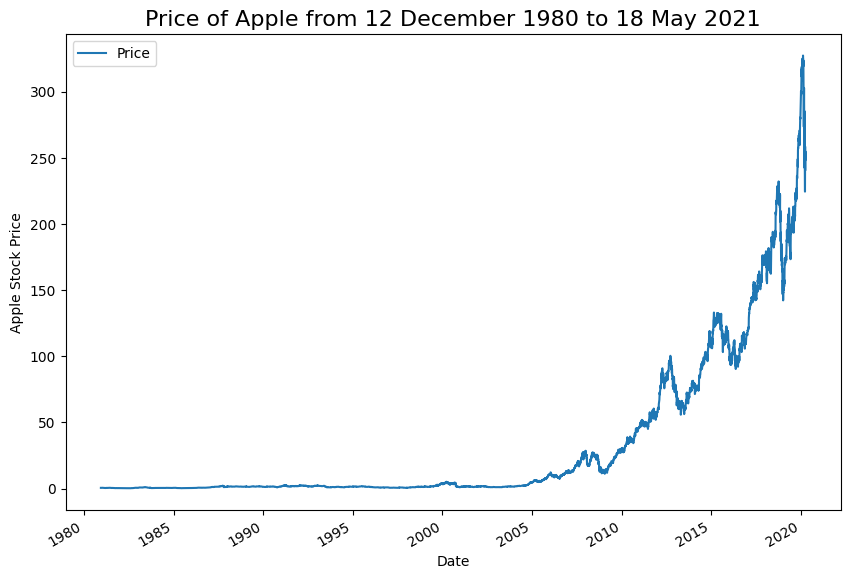

In [200]:
import matplotlib.pyplot as plt

df_price.plot(figsize=(10,7))
plt.title('Price of Apple from 12 December 1980 to 18 May 2021',fontsize=16)
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')

In [201]:
time_step=df_price.index.to_numpy()
price=df_price['Price'].values.astype('float32')
time_step[:10],price[:10]

(array(['1980-12-12T00:00:00.000000000', '1980-12-15T00:00:00.000000000',
        '1980-12-16T00:00:00.000000000', '1980-12-17T00:00:00.000000000',
        '1980-12-18T00:00:00.000000000', '1980-12-19T00:00:00.000000000',
        '1980-12-22T00:00:00.000000000', '1980-12-23T00:00:00.000000000',
        '1980-12-24T00:00:00.000000000', '1980-12-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.51339287, 0.48660713, 0.45089287, 0.46205357, 0.47544643,
        0.50446427, 0.52901787, 0.55133927, 0.58035713, 0.6339286 ],
       dtype=float32))

# Splitting

In [202]:
train_size=int(0.8*len(price))
valid_size=int(0.1*len(price))
test_size=int(0.1*len(price))
print(train_size,valid_size,test_size)

7927 990 990


In [203]:
split_size_train = int(0.8 * len(price))
split_size_val = int(0.1 * len(price))

train_time, train_price = time_step[:split_size_train], price[:split_size_train]
val_time, val_price = time_step[split_size_train:split_size_train + split_size_val], price[split_size_train:split_size_train + split_size_val]
test_time, test_price = time_step[split_size_train + split_size_val:], price[split_size_train + split_size_val:]
len(train_time),len(test_time),len(train_price),len(test_price)

(7927, 992, 7927, 992)

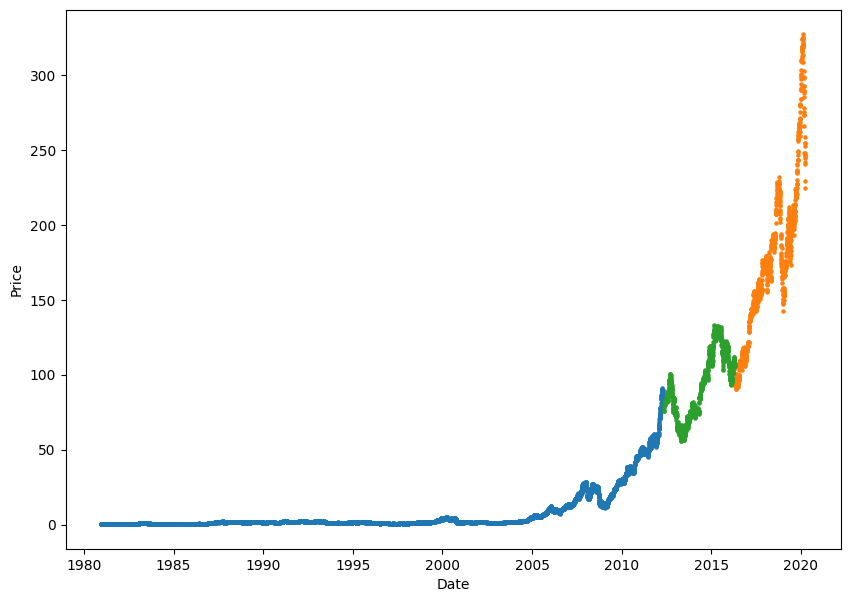

In [204]:
plt.figure(figsize=(10,7))
plt.scatter(train_time, train_price, s=5, label="Train data")
plt.scatter(test_time, test_price, s=5, label="Test data")
plt.scatter(val_time, val_price, s=5, label="val data")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Creating Window Size and Horizon

In [205]:
import torch
def create_dataset(dataset, step):
    X, y = [], []
    for i in range(len(dataset)-step):
        feature = dataset[i:i+step]
        target = dataset[i+step:i+step+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [206]:
step = 5
X_train, y_train = create_dataset(train_price, step=step)
X_val, y_val = create_dataset(val_price, step=step)
X_test, y_test = create_dataset(test_price, step=step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([7922, 5]) torch.Size([7922, 1])
torch.Size([987, 5]) torch.Size([987, 1])


#  Scaling

In [207]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaler.fit(X_train)
y_scaler.fit(X_train.reshape(-1, 1))

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_val = y_scaler.transform(y_val.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

# Baseline Model

In [208]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential()

model.add(LSTM(units=50, activation='relu', input_shape=(5, 1)))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


c:\Users\nsnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and Fitting Baseline Model

In [209]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import Callback

model.compile(loss='mean_squared_error')

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Data generators
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)


class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            y_pred_train = self.model.predict(X_train)
            y_pred_val = self.model.predict(X_val)
            y_pred_test = self.model.predict(X_test)

            train_rmse = np.sqrt(MeanSquaredError()(y_train, y_pred_train).numpy())
            val_rmse = np.sqrt(MeanSquaredError()(y_val, y_pred_val).numpy())
            test_rmse = np.sqrt(MeanSquaredError()(y_test, y_pred_test).numpy())

            train_mae = MeanAbsoluteError()(y_train, y_pred_train).numpy()
            val_mae = MeanAbsoluteError()(y_val, y_pred_val).numpy()
            test_mae = MeanAbsoluteError()(y_test, y_pred_test).numpy()

            train_mape = MeanAbsolutePercentageError()(y_train, y_pred_train).numpy()
            val_mape = MeanAbsolutePercentageError()(y_val, y_pred_val).numpy()
            test_mape = MeanAbsolutePercentageError()(y_test, y_pred_test).numpy()

            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}, test RMSE {test_rmse:.4f}")
            print(f"Epoch {epoch}: train MAE {train_mae:.4f}, val MAE {val_mae:.4f}, test MAE {test_mae:.4f}")
            print(f"Epoch {epoch}: train MAPE {train_mape:.4f}, val MAPE {val_mape:.4f}, test MAPE {test_mape:.4f}")

n_epochs = 50
history = model.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=[MetricsCallback()])




Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 0: train RMSE 0.0084, val RMSE 0.0256, test RMSE 0.1430
Epoch 0: train MAE 0.0072, val MAE 0.0199, test MAE 0.0847
Epoch 0: train MAPE 1024.5813, val MAPE 2.0406, test MAPE 3.5888
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0033 - val_loss: 6.5595e-04
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8352e-05 - val_loss: 8.3460e-04
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4700e-05 - val_loss: 6.0492e-04
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8451e-05 - val_loss: 7.7881e-04
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5612e-05 - val_loss: 0.0011
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8105e-05 - val_loss: 8.0859e-04
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9077e-05 - val_loss: 8.5783e-04
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 2

In [210]:
y_pred_test = model.predict(X_test)

y_test_unscaled = y_scaler.inverse_transform(y_test).flatten()
y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

test_rmse = np.sqrt(MeanSquaredError()(y_test_unscaled, y_pred_test_unscaled).numpy())
test_mae = MeanAbsoluteError()(y_test_unscaled, y_pred_test_unscaled).numpy()
test_mape = MeanAbsolutePercentageError()(y_test_unscaled, y_pred_test_unscaled).numpy()

print(f"Final test RMSE: {test_rmse:.4f}")
print(f"Final test MAE: {test_mae:.4f}")
print(f"Final test MAPE: {test_mape:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
Final test RMSE: 6.8848
Final test MAE: 5.2925
Final test MAPE: 2.8927


- RMSE: 6.8848: Model memiliki kesalahan prediksi rata-rata sekitar 6.88 unit dari nilai sebenarnya.
- MAE: 5.2925: Rata-rata kesalahan absolut adalah sekitar 5.29 unit dari nilai sebenarnya.
- MAPE: 2.8927: Kesalahan prediksi model dalam bentuk persentase adalah sekitar 2.89% dari nilai sebenarnya.

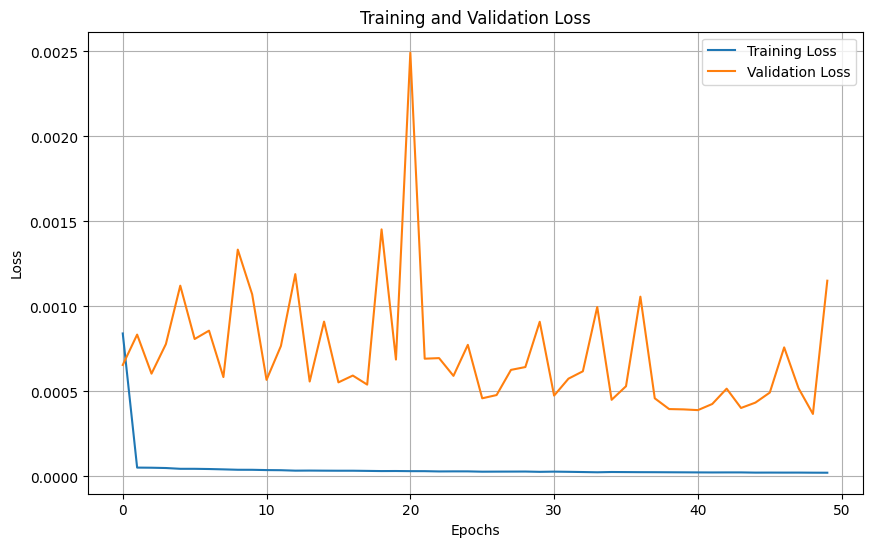

In [211]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
     Test Pred    Actual
0     1.083481  1.030322
1     1.069859  1.047302
2     1.070578  1.036386
3     1.066013  1.025911
4     1.059737  1.020178
..         ...       ...
982   2.757025  2.847430
983   2.853139  2.729450
984   2.839453  2.807405
985   2.883994  2.801671
986   2.893965  2.654142

[987 rows x 2 columns]


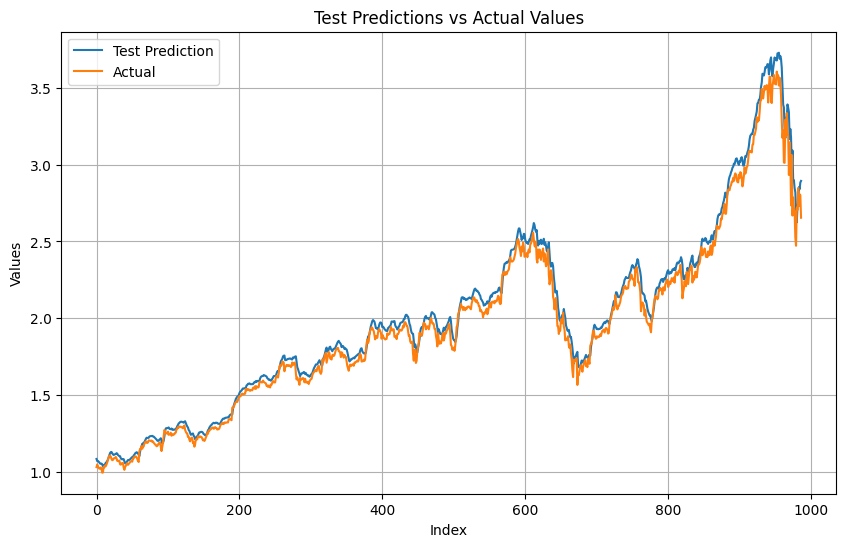

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Melakukan prediksi
y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

test_res = pd.DataFrame(data={'Test Pred': y_pred, 'Actual': y_test})

print(test_res)

plt.figure(figsize=(10, 6))
plt.plot(test_res['Test Pred'], label='Test Prediction')
plt.plot(test_res['Actual'], label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Test Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


# Modified Model

In [229]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()


model.add(LSTM(units=50, return_sequences=True, activation='linear', input_shape=(5, 1)))

model.add(LSTM(units=50, activation='linear'))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


c:\Users\nsnic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

- Input: Urutan data dengan bentuk (5, 1).
- Lapisan LSTM pertama: 50 unit, mengembalikan urutan lengkap.
- return_sequences=True: Menunjukkan bahwa lapisan ini mengembalikan urutan lengkap dari output untuk setiap langkah waktu. Ini diperlukan karena ada lapisan LSTM lain setelahnya yang membutuhkan urutan lengkap ini sebagai input.
- Lapisan LSTM kedua: 50 unit, mengembalikan output pada langkah waktu terakhir.
- Lapisan Dense: 1 unit, menghasilkan output akhir.


In [230]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import Callback

model.compile(optimizer= SGD(learning_rate=0.001), loss='mean_squared_error')

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Data generators
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)


class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            y_pred_train = self.model.predict(X_train)
            y_pred_val = self.model.predict(X_val)
            y_pred_test = self.model.predict(X_test)

            train_rmse = np.sqrt(MeanSquaredError()(y_train, y_pred_train).numpy())
            val_rmse = np.sqrt(MeanSquaredError()(y_val, y_pred_val).numpy())
            test_rmse = np.sqrt(MeanSquaredError()(y_test, y_pred_test).numpy())

            train_mae = MeanAbsoluteError()(y_train, y_pred_train).numpy()
            val_mae = MeanAbsoluteError()(y_val, y_pred_val).numpy()
            test_mae = MeanAbsoluteError()(y_test, y_pred_test).numpy()

            train_mape = MeanAbsolutePercentageError()(y_train, y_pred_train).numpy()
            val_mape = MeanAbsolutePercentageError()(y_val, y_pred_val).numpy()
            test_mape = MeanAbsolutePercentageError()(y_test, y_pred_test).numpy()

            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}, test RMSE {test_rmse:.4f}")
            print(f"Epoch {epoch}: train MAE {train_mae:.4f}, val MAE {val_mae:.4f}, test MAE {test_mae:.4f}")
            print(f"Epoch {epoch}: train MAPE {train_mape:.4f}, val MAPE {val_mape:.4f}, test MAPE {test_mape:.4f}")

n_epochs = 50
history = model.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=[MetricsCallback()])




Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 0: train RMSE 0.1509, val RMSE 0.9546, test RMSE 1.9269
Epoch 0: train MAE 0.0961, val MAE 0.9267, test MAE 1.8398
Epoch 0: train MAPE 10230.6104, val MAPE 90.3106, test MAPE 94.1942
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0240 - val_loss: 0.9129
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0228 - val_loss: 0.8763
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0224 - val_loss: 0.8479
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0228 - val_loss: 0.8196
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0205 - val_loss: 0.7818
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0191 - val_loss: 0.7499
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0189 - val_loss: 0.7225
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0186 - val_loss: 0.6914
Ep

In [231]:
y_pred_test = model.predict(X_test)

y_test_unscaled = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

test_rmse = np.sqrt(MeanSquaredError()(y_test_unscaled, y_pred_test_unscaled).numpy())
test_mae = MeanAbsoluteError()(y_test_unscaled, y_pred_test_unscaled).numpy()
test_mape = MeanAbsolutePercentageError()(y_test_unscaled, y_pred_test_unscaled).numpy()

print(f"Final test RMSE: {test_rmse:.4f}")
print(f"Final test MAE: {test_mae:.4f}")
print(f"Final test MAPE: {test_mape:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final test RMSE: 11.8158
Final test MAE: 7.7814
Final test MAPE: 3.7969


RMSE: 11.8158: Model memiliki kesalahan prediksi rata-rata sekitar 11.82 unit dari nilai sebenarnya.
MAE: 7.7814: Rata-rata kesalahan absolut adalah sekitar 7.78 unit dari nilai sebenarnya.
MAPE: 3.7969: Kesalahan prediksi model dalam bentuk persentase adalah sekitar 3.80% dari nilai sebenarnya.

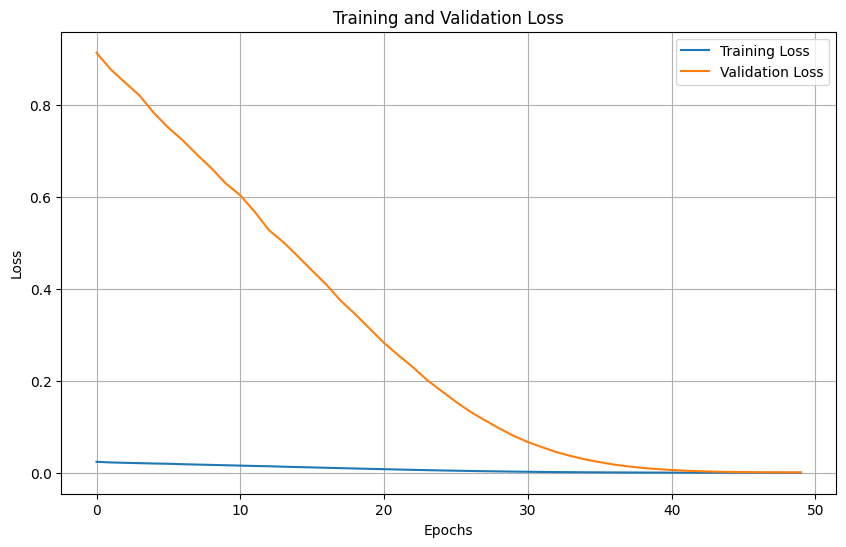

In [232]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Salah satu indikator overfitting adalah jika training loss rendah tetapi validation loss tetap tinggi atau meningkat. Dalam hal ini, baik training loss maupun validation loss menurun dan stabil mendekati nol, yang menunjukkan bahwa model tidak mengalami overfitting.

Training loss yang rendah dan stabil menunjukkan bahwa model mempelajari data training dengan sangat baik.
Validation loss yang menurun secara konsisten menunjukkan bahwa model juga mampu melakukan generalisasi dengan baik terhadap data baru yang tidak terlihat selama pelatihan.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
     Test Pred    Actual
0     1.095571  1.030322
1     1.066078  1.047302
2     1.040486  1.036386
3     1.031565  1.025911
4     1.028859  1.020178
..         ...       ...
982   2.786207  2.847430
983   2.811070  2.729450
984   2.874612  2.807405
985   2.959866  2.801671
986   2.980872  2.654142

[987 rows x 2 columns]


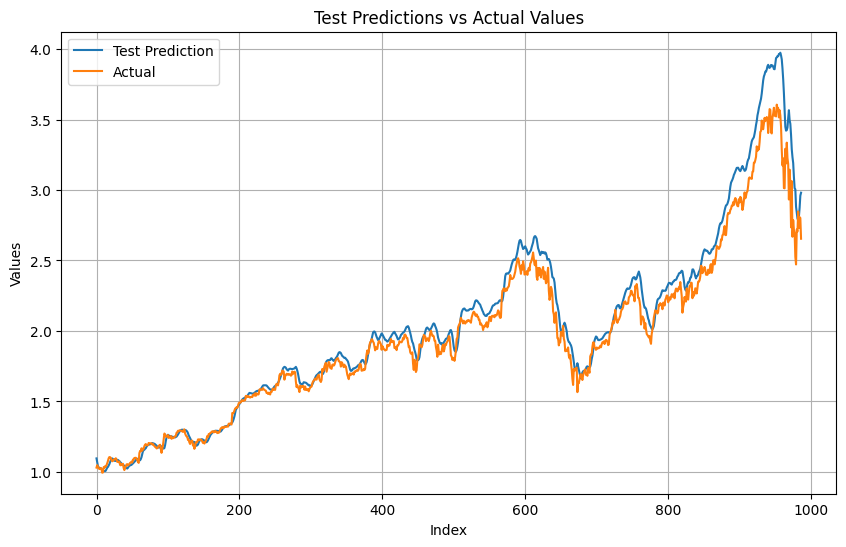

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

test_res = pd.DataFrame(data={'Test Pred': y_pred, 'Actual': y_test})

print(test_res)

plt.figure(figsize=(10, 6))
plt.plot(test_res['Test Pred'], label='Test Prediction')
plt.plot(test_res['Actual'], label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Test Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


Secara umum, kurva biru (prediksi) mengikuti kurva oranye (nilai aktual) dengan baik.
Ini menunjukkan bahwa model cukup baik dalam menangkap pola dan tren utama dalam data.
Pada beberapa bagian, terutama di bagian puncak tertinggi dan lembah terdalam, prediksi cenderung lebih tinggi atau lebih rendah dibandingkan nilai aktual.
Kesalahan ini bisa diakibatkan oleh model yang mungkin tidak sepenuhnya menangkap volatilitas ekstrem dalam data.